In [1]:
# import python libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from scipy import stats

In [2]:
# set plotting settings
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 18
#rcParams['figure.figsize'] = [8, 4]
#rcParams['figure.dpi'] = 300

In [3]:
# set seaborn style 
sns.set()
sns.set_style("whitegrid")

In [4]:
# import spatial libraries
import geopandas as gpd
from shapely.geometry import Point,Polygon

### Estract OSM data

In [5]:
# import OpenStreetMap libraries
import osmium as osm
import pandas as pd

In [6]:
# define OSMHandler class
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type):
        for tag in elem.tags:
            # append only way tags, only relevant info
            if elem_type == "way":
                self.osm_data.append([ elem.id, tag.k, tag.v])

    def node(self, n):
        self.tag_inventory(n, "node")

    def way(self, w):
        self.tag_inventory(w, "way")

    def relation(self, r):
        self.tag_inventory(r, "relation")

In [ ]:
# create osmhandler object
osmhandler = OSMHandler()
# scan the input file and fills the handler list accordingly
osmhandler.apply_file("italy-latest.osm.pbf")

In [ ]:
# save data into Pandas dataframe
df_osm = pd.DataFrame(osmhandler.osm_data, columns=['id','tagkey', 'tagvalue'])
df_osm.head()

In [ ]:
# save file as CSV
df_osm.to_csv("Italy-osm-ways.csv")

### Large scale validation

In [5]:
# load dataset
df = pd.read_csv("Italy_ppe.csv") 
df = df.drop(columns="Unnamed: 0")

# remove outliers top as in Alessandroni et al. 2014
df = df[(df["ppe"] > 0.001 ) & (df["ppe"] < 4)]  

# remove bottom 1%
df = df[df["ppe"] > df["ppe"].quantile(0.01) ] 

# calculate logarithm of ppe
df["log_ppe"] = np.log(df["ppe"])

df.head() 

,latitude,longitude,ppe,osm_id,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.389328
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.240700
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.373763
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.337885
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-0.610605


In [6]:
# selected roads - colors dictionary

roads = ["motorway", "trunk", "primary", "secondary", "tertiary",  "unclassified", "residential"] 
colors = ["blue", "darkorange", "green", "red",  "gray",  "violet", "purple"]

zip_iterator = zip(roads, colors)
col_dict = dict(zip_iterator)
print(col_dict)

{'motorway': 'blue', 'trunk': 'darkorange', 'primary': 'green', 'secondary': 'red', 'tertiary': 'gray', 'unclassified': 'violet', 'residential': 'purple'}


In [7]:
# load highway tag file
df_osm = pd.read_csv(r"Italy-osm-ways.csv")
df_osm = df_osm.drop(columns = "Unnamed: 0")
df_osm.head()

,id,tagkey,tagvalue
0,2954434,lit,no
1,2954434,ref,RA 9
2,2954434,name,Raccordo autostradale 9 di Benevento
3,2954434,toll,no
4,2954434,lanes,2


#### Presence of a Bridge 

In [8]:
# extract bridge tags
bridge = df_osm[df_osm["tagkey"]=="bridge"].drop(columns = "tagkey").set_index("id", drop = True).rename(columns={"tagvalue": "bridge"})
bridge.head()

,bridge
id,
2954434,yes
5019067,yes
6059135,yes
6059228,yes
6059326,yes


In [9]:
# add bridge tag to data
df = df.set_index("osm_id", drop = True).join(bridge)
df.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,bridge
-3328048,41.749796,12.708312,0.214824,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.537936,NaN
-3328048,41.749724,12.708504,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN
-3328048,41.749688,12.708712,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN
-3328048,41.749696,12.708922,0.242806,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.415492,NaN
-3328048,41.749677,12.709130,0.247774,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.395238,NaN


In [10]:
# define function to calculate confidence interval for calculated statistics

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m - h, m + h

#alternative
#lowerb, upperb = stats.t.interval(0.95, len(d1_)-1, loc=np.mean(d1_), scale=stats.sem(d1_))

In [11]:
# only consider large (important) roads that have expansion joints
large_roads = roads[:4]

# calculate the statistics for points not mapped on bridges
d1 = df[((df["bridge"].isna())) & (df["road"].isin(large_roads))]
# calculate mean in the transformed domain
stats_nob = d1.groupby(["road"]).log_ppe.mean().reset_index(name = "mean")
# reindex dataframe
stats_nob = stats_nob.set_index("road", drop = True).reindex(large_roads)
# count points
stats_nob["count"] = d1.groupby(["road"]).log_ppe.size()
# calculate standard deviation in the transformed domain
stats_nob["std"] = d1.groupby(["road"]).log_ppe.std()

means = []
lowerb = []
upperb = []
for r in large_roads:
    data = d1[d1["road"]==r]["log_ppe"]
    m, l, u = mean_confidence_interval(data)
    means.append(np.exp(m))
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
stats_nob["geo_mean"] = means
stats_nob["lowerb"] = lowerb
stats_nob["upperb"] = upperb
stats_nob

,mean,count,std,geo_mean,lowerb,upperb
road,,,,,,
motorway,-2.036680,522953,0.882582,0.130461,0.130149,0.130774
trunk,-2.027330,274091,1.000870,0.131687,0.131194,0.132181
primary,-2.182478,479198,1.054394,0.112762,0.112426,0.113099
secondary,-2.071265,526240,1.081281,0.126026,0.125659,0.126395


In [12]:
# calculate the statistics for points mapped on bridges
d2 = df[((df["bridge"].notna())) & (df["road"].isin(large_roads))]
# calculate mean in the transformed domain
stats_b = d2.groupby(["road"]).log_ppe.mean().reset_index(name = "mean")
# reindex dataframe
stats_b = stats_b.set_index("road", drop = True).reindex(large_roads)
# count points
stats_b["count"] = d2.groupby(["road"]).log_ppe.size()
# calculate standard deviation in the transformed domain
stats_b["std"] = d2.groupby(["road"]).log_ppe.std()

means = []
lowerb = []
upperb = []
for r in large_roads:
    data = d2[d2["road"]==r]["log_ppe"]
    m, l, u = mean_confidence_interval(data)
    means.append(np.exp(m))
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
stats_b["geo_mean"] = means
stats_b["lowerb"] = lowerb
stats_b["upperb"] = upperb
stats_b

,mean,count,std,geo_mean,lowerb,upperb
road,,,,,,
motorway,-1.719677,65922,0.974178,0.179124,0.177797,0.180461
trunk,-1.787681,32756,0.977445,0.167348,0.165586,0.169129
primary,-1.923239,20661,0.999586,0.146133,0.144154,0.148138
secondary,-1.875595,9077,1.062221,0.153264,0.149950,0.156650


In [13]:
# apply independent t-test to compare points on a bridge and not on a bridge
for r in large_roads:
    d1_ = d1[d1["road"]== r]["log_ppe"]
    d2_ = d2[d2["road"]== r]["log_ppe"]
    s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
    print(r + ": p-value = " + str(pv))

motorway: p-value = 0.0
trunk: p-value = 0.0
primary: p-value = 3.1949411185669984e-282
secondary: p-value = 9.851634537671875e-67


<ipython-input-14-f75f94bd67e9>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_list[i].set_xticklabels(x, rotation=45)


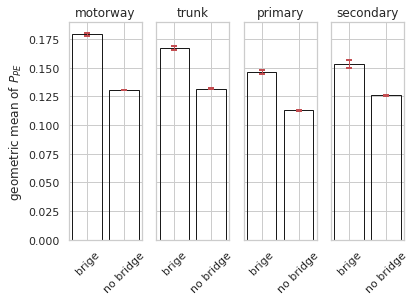

In [14]:
#plot geometric mean of ppe in bridge points and non-bridge points of large roads

f, ax_list = plt.subplots(1, len(large_roads), sharey=True)

for i,r in enumerate(large_roads):
    # plot bars
    x = ["brige","no bridge"]
    y = [stats_b.iat[i,3], stats_nob.iat[i,3]]

    # creating error
    y_errormin = [stats_b.iat[i,3] - stats_b.iat[i,4], stats_nob.iat[i,3] - stats_nob.iat[i,4]]
    y_errormax = [stats_b.iat[i,5] - stats_b.iat[i,3], stats_nob.iat[i,5] - stats_nob.iat[i,3]]
    y_error = [y_errormin, y_errormax]

    ax_list[i].bar(x, y, yerr=y_error, edgecolor='k', color='None', lw = 1, 
                   error_kw=dict(ecolor='r', lw=1, capsize=3, capthick=2))
    ax_list[i].set_title(r)
    ax_list[i].set_xticklabels(x, rotation=45)

ax_list[0].set_ylabel("geometric mean of $P_{PE}$")    
plt.savefig("fig9.svg", format='svg', transparent=True)
plt.show()

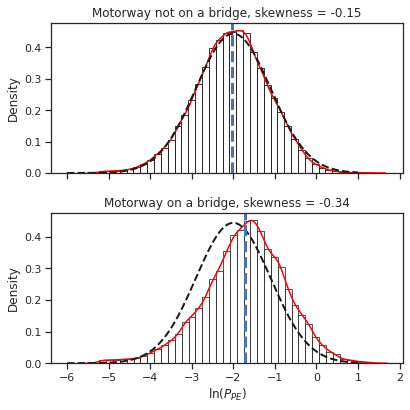

In [15]:
# plot distribution of equal-sized samples of bridge and non-bridge points in motorways

import random
from scipy.stats import norm

sns.set(style="ticks")

rcParams['figure.figsize'] = [6, 6]

road = "motorway"

f, (ax_hist1, ax_hist2) = plt.subplots(2, sharex=True)

# count bridge points in motorways
l = len(df[(df['bridge'].notna()) & (df["road"]==road)]["log_ppe"])

# estract a sample of the same size from no bridge roads
nob = df[(df["road"]==road) & df["bridge"].isna()]["log_ppe"]
d = random.sample(list(nob), l )
sns.histplot(d, ax=ax_hist1, bins= 40, facecolor="white", edgecolor='black', stat= "density")
sns.kdeplot(d, ax=ax_hist1, color = "red")

# plot best fit normal distribution             
x = np.linspace(-6, 1, 1000)
mean, std = norm.fit(df[df["road"] == "motorway"]["log_ppe"])
p = norm.pdf(x, mean, std)
ax_hist1.plot(x, p, 'k', linewidth=2, ls = "--")
ax_hist1.axvline(x = sum(d)/len(d), linewidth=3, ls = "--", color = "b")

# extract bridge points
d2 = df[(df['bridge'].notna()) & (df["road"]==road)]["log_ppe"]
sns.histplot(d2, ax=ax_hist2, bins= 40, facecolor="white", edgecolor='black', stat= "density")
sns.kdeplot(d2, ax=ax_hist2, color = "red")
ax_hist2.plot(x, p, 'k', linewidth=2, ls = "--")
ax_hist2.axvline(x = sum(d2)/len(d2), linewidth=3, ls = "--", color = "b")

ax_hist1.set_title("Motorway not on a bridge, skewness = " + str(round(pd.Series(d).skew(),2)) )
ax_hist2.set_title("Motorway on a bridge, skewness = " + str(round(d2.skew(),2)))

ax_hist2.set_xlabel("ln($P_{PE}$)")
plt.tight_layout(pad=1.5)

#plt.savefig("fig10a.svg", format='svg', transparent=True)
plt.show()

In [16]:
# apply the Kolmogorov-Smirnov test to bridge points
c,pv = stats.kstest(stats.norm.rvs(loc = mean, scale = std, size=1000), d2)
# p-value
pv

2.0451269696381654e-18

In [17]:
# apply the Kolmogorov-Smirnov test to non-bridge points
c,pv = stats.kstest(stats.norm.rvs(loc = mean, scale = std, size=1000), d)
# p-value
pv

0.0556818632585353

#### Pavement materials and construction

In [18]:
# extract surface tags
surface = df_osm[df_osm["tagkey"]=="surface"].drop(columns = "tagkey").set_index("id", drop = True).rename(columns={"tagvalue": "surface"})
surface = surface.replace("cobblestone:flattened","cobblestone")
surface = surface.replace("paving_stones","paving stones")
surface = surface.replace("concrete:plates","plates")
surface = surface.replace("fine_gravel","gravel")
surface.head()

,surface
id,
3211740,asphalt
6059125,asphalt
6059135,asphalt
6059138,asphalt
6059142,asphalt


In [19]:
# add surface tags to dataset
df = df.join(surface)
df.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,bridge,surface
-3328048,41.749796,12.708312,0.214824,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.537936,NaN,NaN
-3328048,41.749724,12.708504,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN,NaN
-3328048,41.749688,12.708712,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN,NaN
-3328048,41.749696,12.708922,0.242806,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.415492,NaN,NaN
-3328048,41.749677,12.709130,0.247774,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.395238,NaN,NaN


In [20]:
# list unspecific tags (according to OSM)
unspecific = ["dirt", "ground", "gravel", "unpaved", "paved"]

In [21]:
# calculate mean for each surface material
stats_s = df.groupby(["surface"]).log_ppe.agg(["count","mean"]).reset_index().sort_values(by = "mean", ascending = False)
stats_s = stats_s[stats_s["count"]>100].reset_index(drop = True)
stats_s = stats_s[~stats_s["surface"].isin(unspecific)]
stats_s

,surface,count,mean
0,plates,385,0.001128
1,cobblestone,793,-0.894626
2,sett,1772,-0.936386
3,compacted,1371,-1.770166
4,paving stones,1158,-1.878719
7,concrete,331,-2.006967
8,asphalt,1385369,-2.009657


In [22]:
# calculate confidence intervals for roads of different materials
materials = list(stats_s["surface"])

means = []
lowerb = []
upperb = []

for m in materials:
    data = df[df["surface"]==m]["log_ppe"]
    m, l, u = mean_confidence_interval(data)
    means.append(np.exp(m))
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
stats_s["geo_mean"] = means
stats_s["lowerb"] = lowerb
stats_s["upperb"] = upperb
stats_s

,surface,count,mean,geo_mean,lowerb,upperb
0,plates,385,0.001128,1.001128,0.897695,1.116478
1,cobblestone,793,-0.894626,0.408761,0.368541,0.453369
2,sett,1772,-0.936386,0.392042,0.368381,0.417223
3,compacted,1371,-1.770166,0.170305,0.158872,0.182560
4,paving stones,1158,-1.878719,0.152786,0.141830,0.164588
7,concrete,331,-2.006967,0.134396,0.118524,0.152392
8,asphalt,1385369,-2.009657,0.134035,0.133808,0.134262


Text(0.5, 1.0, 'geo. mean and 95% CI of $P_{PE}$')

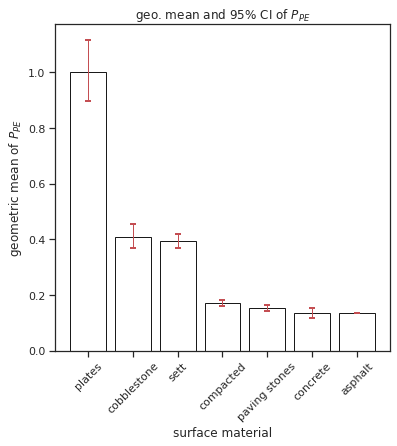

In [23]:
# plot geometric mean and interval of confidence
x = materials
y = stats_s["geo_mean"]

# calculating error
y_errormin = stats_s["geo_mean"] - stats_s["lowerb"]
y_errormax = stats_s["upperb"] - stats_s["geo_mean"]
y_error = [y_errormin, y_errormax]

plt.bar(x, y, yerr=y_error, edgecolor='k', color='None', lw = 1, error_kw=dict(ecolor='r', lw=1, capsize=3, capthick=2))

plt.xticks(rotation=45)
plt.xlabel("surface material")
plt.ylabel("geometric mean of $P_{PE}$")
plt.title("geo. mean and 95% CI of $P_{PE}$")

#plt.savefig("fig11.svg", format='svg', transparent=True)

In [24]:
materials

['plates',
 'cobblestone',
 'sett',
 'compacted',
 'paving stones',
 'concrete',
 'asphalt']

In [25]:
# extract log ppe values for each material
d1_ = df[df["surface"]== 'plates']["log_ppe"]
d2_ = df[df["surface"]== 'cobblestone']["log_ppe"]
d3_ = df[df["surface"]== 'sett']["log_ppe"]
d4_ = df[df["surface"]== 'compacted']["log_ppe"]
d5_ = df[df["surface"]== 'paving stones']["log_ppe"]
d6_ = df[df["surface"]== 'concrete']["log_ppe"]
d7_ = df[df["surface"]== 'asphalt']["log_ppe"]

In [29]:
# apply Kruskal test to compare multiple groups
stats.kruskal(d1_, d2_, d3_, d4_, d5_, d6_, d7_)

KruskalResult(statistic=2602.379165665208, pvalue=0.0)

In [33]:
# apply t-test and kruskal test 2 by 2 to indetify pair of similar materials
for i, m1 in enumerate(materials):
    for j, m2 in enumerate(materials):
        d1_ = df[df["surface"]== m1]["log_ppe"]
        d2_ = df[df["surface"]== m2]["log_ppe"]
        if j < i:
            s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
            s2, pv2 = stats.kruskal(d1_, d2_)
            print(m1 + " + " + m2 + ": t-test pv = " + str(round(pv,3)) + "; kruskal pv = " + str(round(pv2,3)))

cobblestone + plates: t-test pv = 0.0; kruskal pv = 0.0
sett + plates: t-test pv = 0.0; kruskal pv = 0.0
sett + cobblestone: t-test pv = 0.498; kruskal pv = 0.177
compacted + plates: t-test pv = 0.0; kruskal pv = 0.0
compacted + cobblestone: t-test pv = 0.0; kruskal pv = 0.0
compacted + sett: t-test pv = 0.0; kruskal pv = 0.0
paving stones + plates: t-test pv = 0.0; kruskal pv = 0.0
paving stones + cobblestone: t-test pv = 0.0; kruskal pv = 0.0
paving stones + sett: t-test pv = 0.0; kruskal pv = 0.0
paving stones + compacted: t-test pv = 0.037; kruskal pv = 0.005
concrete + plates: t-test pv = 0.0; kruskal pv = 0.0
concrete + cobblestone: t-test pv = 0.0; kruskal pv = 0.0
concrete + sett: t-test pv = 0.0; kruskal pv = 0.0
concrete + compacted: t-test pv = 0.001; kruskal pv = 0.0
concrete + paving stones: t-test pv = 0.085; kruskal pv = 0.089
asphalt + plates: t-test pv = 0.0; kruskal pv = 0.0
asphalt + cobblestone: t-test pv = 0.0; kruskal pv = 0.0
asphalt + sett: t-test pv = 0.0; krus

In [39]:
d = df[(df["surface"].isin(materials)) & (df["road"].isin(roads))]
# group by road type and material
dgc = d.groupby(["road","surface"]).log_ppe.agg("count")
dgc

road          surface      
motorway      asphalt          478018
primary       asphalt          220881
              cobblestone          13
              paving stones        33
              sett                 64
residential   asphalt           38316
              cobblestone         220
              compacted            75
              concrete             75
              paving stones       540
              plates                9
              sett                867
secondary     asphalt          255608
              cobblestone         186
              paving stones        55
              plates              216
              sett                185
tertiary      asphalt          168721
              cobblestone         218
              compacted           324
              concrete              7
              paving stones       299
              plates              155
              sett                409
trunk         asphalt          119528
unclassified  asphalt 

In [40]:
# calculate geometric mean per road type and surface material
d = df[(df["surface"].isin(materials)) & (df["road"].isin(roads))]
dg = d.groupby(["road","surface"]).log_ppe.agg("mean")
dg = np.exp(dg).round(2)
dg = dg.unstack(level=1).T
dg = dg[roads]
dg = dg.reindex(materials)
dg

road,motorway,trunk,primary,secondary,tertiary,unclassified,residential
surface,,,,,,,
plates,NaN,NaN,NaN,0.64,2.03,NaN,0.63
cobblestone,NaN,NaN,2.26,0.71,0.69,0.15,0.30
sett,NaN,NaN,1.44,0.82,0.58,0.35,0.27
compacted,NaN,NaN,NaN,NaN,0.17,0.16,0.09
paving stones,NaN,NaN,0.40,0.20,0.14,0.18,0.14
concrete,NaN,NaN,NaN,NaN,0.09,0.13,0.16
asphalt,0.14,0.14,0.12,0.13,0.14,0.15,0.13


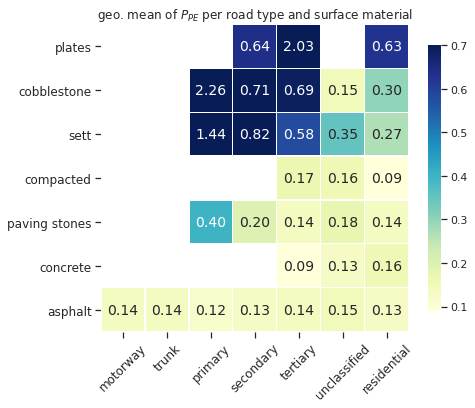

In [41]:
# plot geometric mean of ppe per surface material and road type
rcParams['figure.figsize'] = [7, 7]
ax = sns.heatmap(dg, cmap="YlGnBu", vmax=.7, square=True, fmt=".2f", annot=True, linewidths=.2,
                 annot_kws={"size": 14}, cbar_kws={"shrink": 0.6})
ax.set_aspect("equal")
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=45, fontsize = 12) 
#plt.title("Mean PPE per road type and surface type")
plt.xlabel("")
plt.ylabel("")
plt.title("geo. mean of $P_{PE}$ per road type and surface material" )
plt.tight_layout()

plt.savefig("fig12.svg", format='svg', transparent=True)

In [42]:
# extract motorway data
mdf = df[df["road"]== "motorway"]

In [43]:
# add maxspeed values
max_speeds = df_osm[df_osm["tagkey"]=="maxspeed"].drop(columns = "tagkey").set_index("id", drop = True).rename(columns={"tagvalue": "maxspeed"})
max_speeds = max_speeds.replace("IT:rural",90)
max_speeds = max_speeds.replace("IT:urban",50)
max_speeds = max_speeds.replace("25 mph", 40)
max_speeds = max_speeds.replace("signals",np.NaN)
max_speeds = max_speeds.replace("30;90",np.NaN)
max_speeds = max_speeds.replace("90;50;30",np.NaN)
max_speeds = max_speeds.replace("50;30",np.NaN)
max_speeds = max_speeds.replace("70; 50",np.NaN)
max_speeds['maxspeed'] = pd.to_numeric(max_speeds['maxspeed'], errors='coerce')
max_speeds.head()

,maxspeed
id,
2954434,80.0
3211740,40.0
4589499,130.0
6009429,40.0
6059125,50.0


In [28]:
# add maxspeed data to dataset
df = df.join(max_speeds)
df.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,bridge,surface,maxspeed
-3328048,41.749796,12.708312,0.214824,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.537936,NaN,NaN,NaN
-3328048,41.749724,12.708504,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN,NaN,NaN
-3328048,41.749688,12.708712,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN,NaN,NaN
-3328048,41.749696,12.708922,0.242806,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.415492,NaN,NaN,NaN
-3328048,41.749677,12.709130,0.247774,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.395238,NaN,NaN,NaN


### POPULATION / TRAFFIC

In [45]:
# read population data
demo = pd.read_csv("cities_statistics.csv") 
demo.columns = ["COD_REG", "COD_COM", "NAME_COM", "Area", "Population", "Altitude", "Altitude_center", "Urbanization"]
demo

,COD_REG,COD_COM,NAME_COM,Area,Population,Altitude,Altitude_center,Urbanization
0,1,1001,Agliè,13.15,2621,3,315,2
1,1,1002,Airasca,15.74,3598,5,257,3
2,1,1003,Ala di Stura,46.33,441,1,1080,3
3,1,1004,Albiano d'Ivrea,11.73,1644,3,230,3
4,1,1006,Almese,17.88,6426,3,364,2
...,...,...,...,...,...,...,...,...
7898,20,111103,Villaputzu,181.31,4604,4,8,3
7899,20,111104,Villasalto,130.36,1011,3,502,3
7900,20,111105,Villasimius,57.97,3714,4,41,3
7901,20,111106,Villasor,86.79,6818,5,25,2


In [46]:
# add population data to dataset
dfp = df.set_index('COD_COM').join(demo.set_index('COD_COM'),  lsuffix = '_left', rsuffix = '_right').rename_axis('NOME_COM').reset_index()
dfp

,NOME_COM,latitude,longitude,ppe,road,timestamp,index_right,COD_REG_left,COD_PRO,NAME_COM_left,...,log_ppe,bridge,surface,COD_REG_right,NAME_COM_right,Area,Population,Altitude,Altitude_center,Urbanization
0,1002.0,44.937592,7.503855,0.040024,motorway,2015-04-12 18:52:13.007001,369.0,1.0,1.0,Airasca,...,-3.218285,NaN,NaN,1.0,Airasca,15.74,3598.0,5.0,257.0,3.0
1,1002.0,44.938075,7.504125,0.044872,motorway,2015-04-12 18:54:19.864824,369.0,1.0,1.0,Airasca,...,-3.103938,NaN,NaN,1.0,Airasca,15.74,3598.0,5.0,257.0,3.0
2,1002.0,44.937914,7.504037,0.043660,motorway,2015-04-12 18:54:19.864824,369.0,1.0,1.0,Airasca,...,-3.131322,NaN,NaN,1.0,Airasca,15.74,3598.0,5.0,257.0,3.0
3,1002.0,44.937753,7.503946,0.043764,motorway,2015-04-12 18:54:19.864824,369.0,1.0,1.0,Airasca,...,-3.128939,NaN,NaN,1.0,Airasca,15.74,3598.0,5.0,257.0,3.0
4,1002.0,44.937392,7.503722,0.052071,motorway,2015-04-12 18:52:13.007001,369.0,1.0,1.0,Airasca,...,-2.955145,NaN,asphalt,1.0,Airasca,15.74,3598.0,5.0,257.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024476,110009.0,41.247182,16.345295,0.501952,motorway,2016-08-27 12:51:53.978143,8069.0,16.0,110.0,Trani,...,-0.689252,NaN,asphalt,16.0,Trani,103.41,55405.0,5.0,7.0,1.0
3024477,110009.0,41.247270,16.345085,0.022357,motorway,2016-08-27 12:53:32.252262,8069.0,16.0,110.0,Trani,...,-3.800616,NaN,asphalt,16.0,Trani,103.41,55405.0,5.0,7.0,1.0
3024478,110009.0,41.247270,16.345085,0.022357,motorway,2016-08-27 12:53:32.252262,8069.0,16.0,110.0,Trani,...,-3.800616,NaN,asphalt,16.0,Trani,103.41,55405.0,5.0,7.0,1.0
3024479,110009.0,41.247356,16.344873,0.016548,motorway,2016-08-27 12:53:32.252262,8069.0,16.0,110.0,Trani,...,-4.101510,NaN,asphalt,16.0,Trani,103.41,55405.0,5.0,7.0,1.0


In [47]:
# bin points based on population range of the afferent city
points_pop = [0,1000,10000,100000,200000,500000,5000000]
dfp = dfp[dfp["road"].isin(roads)]
# bin data based on population size
dfp["pop_bins"] = pd.cut(dfp["Population"], points_pop)

#only consider cities with more than 50 points mapped

ppe_pop = dfp.groupby(["pop_bins","road"]).log_ppe.mean()

ppe_pop = ppe_pop.unstack(level = 1)
ppe_pop = np.exp(ppe_pop)
ppe_pop = ppe_pop[roads]
ppe_pop

<ipython-input-47-f855a50ccca4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["pop_bins"] = pd.cut(dfp["Population"], points_pop)


road,motorway,trunk,primary,secondary,tertiary,unclassified,residential
pop_bins,,,,,,,
"(0, 1000]",0.161913,0.133282,0.119298,0.135555,0.129662,0.149590,0.117183
"(1000, 10000]",0.146864,0.135474,0.112174,0.134129,0.145737,0.150589,0.124980
"(10000, 100000]",0.126323,0.142420,0.114185,0.123445,0.142264,0.152952,0.143449
"(100000, 200000]",0.133785,0.142637,0.113877,0.108732,0.124942,0.135964,0.123419
"(200000, 500000]",0.118816,0.093713,0.093909,0.084534,0.075893,0.095375,0.071879
"(500000, 5000000]",0.144420,0.171266,0.146332,0.163625,0.178159,0.124137,0.162808


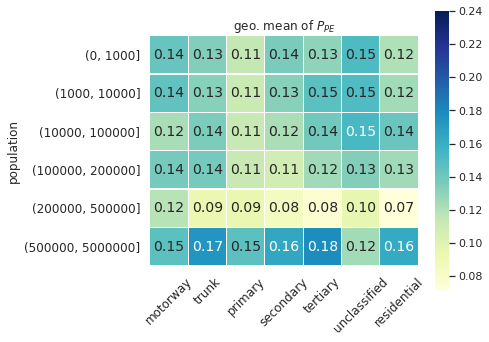

In [12]:
# plot geometric mean of ppe per road type and population range
rcParams['figure.figsize'] = [7, 7]

sns_plot = sns.heatmap(ppe_pop, cmap="YlGnBu", vmax=.24, square=True, fmt=".2f", annot=True, 
                       annot_kws={"size": 14}, linewidths=.2, cbar_kws={"shrink": 0.6})
sns_plot.set_aspect("equal")
sns_plot.set_ylabel("population")
sns_plot.set_xlabel("")
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=45, fontsize = 12) 
plt.title("geo. mean of $P_{PE}$")
plt.tight_layout()

plt.savefig("fig21.svg", format='svg', transparent=True)

In [16]:
# calculate geometric mean per urbanization level
urb = pd.DataFrame(data = {"urbanization" : [1,2,3]})

means = []
lowerb = []
upperb = []
for u in [1,2,3]:
    data = dfp[dfp["Urbanization"]==u]["log_ppe"]
    m, l, u = mean_confidence_interval(data)
    means.append(np.exp(m))
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))

urb["mean"] = means
urb["upperb"] = upperb
urb["lowerb"] = lowerb
urb

,urbanization,mean,upperb,lowerb
0,1,0.131162,0.131519,0.130807
1,2,0.125879,0.126115,0.125644
2,3,0.136495,0.136808,0.136183


In [55]:
# compare roads in cities with urbanization level 1 and 2
d1_ = dfp[dfp["Urbanization"]== 1]["log_ppe"]
d2_ = dfp[dfp["Urbanization"]== 2]["log_ppe"]
s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
print(" urbanization 1 vs 2, p-value = " + str(round(pv,3)))

 urbanization 1 vs 2, p-value = 0.0


In [56]:
# compare roads in cities with urbanization level 1 and 3
d1_ = dfp[dfp["Urbanization"]== 1]["log_ppe"]
d2_ = dfp[dfp["Urbanization"]== 3]["log_ppe"]
s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
print(" urbanization 1 vs 3, p-value = " + str(round(pv,3)))

 urbanization 1 vs 3, p-value = 0.0


In [57]:
# compare roads in cities with urbanization level 2 and 3
d1_ = dfp[dfp["Urbanization"]== 2]["log_ppe"]
d2_ = dfp[dfp["Urbanization"]== 3]["log_ppe"]
s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
print(" urbanization 2 vs 3, p-value = " + str(round(pv,3)))

 urbanization 2 vs 3, p-value = 0.0


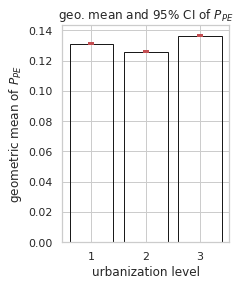

In [17]:
# plot geometric mean of ppe in roads with urbanization level 1,2,3
rcParams['figure.figsize'] = [3, 4]

x = [1,2,3]
y = urb["mean"]

# creating error
y_errormin = urb["mean"] - urb["lowerb"]
y_errormax = urb["upperb"] - urb["mean"]
y_error = [y_errormin, y_errormax]

plt.bar(x, y, yerr=y_error, edgecolor='k', color='None', lw = 1, error_kw=dict(ecolor='r', lw=1, capsize=3, capthick=2))
plt.xlabel("urbanization level")
plt.ylabel("geometric mean of $P_{PE}$")
plt.title("geo. mean and 95% CI of $P_{PE}$")

plt.savefig("fig22.svg", format='svg', transparent=True)

In [44]:
# import shapefile of Italian regions and provinces for plotting
italy_provinces = gpd.read_file('geojson_italy_cities/italy_all_provinces.geojson')
italy_cities = gpd.read_file('geojson_italy_cities/italy_all_cities.geojson')

In [45]:
# extract motorway points
mdf = df[df["road"]== "motorway"]
# create geometry points
geometry=[Point(xy) for xy in zip(mdf["longitude"], mdf["latitude"])] 
# create geodataframe
mdfg = gpd.GeoDataFrame(mdf, crs="EPSG:4326", geometry=geometry) 
mdfg.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,bridge,surface,geometry
-3306416,45.507056,9.618942,0.021378,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.845382,NaN,NaN,POINT (9.61894 45.50706)
-3306416,45.507139,9.619179,0.021922,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.820250,NaN,NaN,POINT (9.61918 45.50714)
-3306416,45.506974,9.618706,0.040609,motorway,2018-08-28 04:18:32.34548,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.203758,NaN,NaN,POINT (9.61871 45.50697)
-3306416,45.505598,9.494273,0.038818,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-3.248881,NaN,NaN,POINT (9.49427 45.50560)
-3306416,45.505602,9.494524,0.055841,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-2.885251,NaN,NaN,POINT (9.49452 45.50560)


In [46]:
# assign colour to points according to ppe as in SRS visualization tool
ppe_points = [0, 0.3, 0.5, 0.7, 1, 1.7, 4]
ppe_colors = ["#78ad4d", "#e9e25b", "#f3a65a", "#fd6959", "#ca5755", "#76504f"]
bins = pd.cut(mdfg["ppe"], ppe_points) 
mdfg["bins"] = bins
ppe_ranges = list(mdfg["bins"].sort_values().unique())

In [47]:
# add color columns
zip_iterator = zip(ppe_ranges, ppe_colors)
ppe_dict = dict(zip_iterator)
print(ppe_dict)
mdfg['color_ppe']= mdfg['bins'].map(ppe_dict)
mdfg.head()

{Interval(0.0, 0.3, closed='right'): '#78ad4d', Interval(0.3, 0.5, closed='right'): '#e9e25b', Interval(0.5, 0.7, closed='right'): '#f3a65a', Interval(0.7, 1.0, closed='right'): '#fd6959', Interval(1.0, 1.7, closed='right'): '#ca5755', Interval(1.7, 4.0, closed='right'): '#76504f'}


,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,bridge,surface,geometry,bins,color_ppe
-3306416,45.507056,9.618942,0.021378,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.845382,NaN,NaN,POINT (9.61894 45.50706),"(0.0, 0.3]",#78ad4d
-3306416,45.507139,9.619179,0.021922,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.820250,NaN,NaN,POINT (9.61918 45.50714),"(0.0, 0.3]",#78ad4d
-3306416,45.506974,9.618706,0.040609,motorway,2018-08-28 04:18:32.34548,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.203758,NaN,NaN,POINT (9.61871 45.50697),"(0.0, 0.3]",#78ad4d
-3306416,45.505598,9.494273,0.038818,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-3.248881,NaN,NaN,POINT (9.49427 45.50560),"(0.0, 0.3]",#78ad4d
-3306416,45.505602,9.494524,0.055841,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-2.885251,NaN,NaN,POINT (9.49452 45.50560),"(0.0, 0.3]",#78ad4d


In [48]:
#extract points in Raccordo Anulare
raccordo_id = df_osm[df_osm["tagvalue"] == "Grande Raccordo Anulare"].id.unique()

In [49]:
#create a legend for maps
import matplotlib.patches as mpatches
ppe_legend = []
for key in ppe_dict:
    ppe_legend.append(mpatches.Patch(color=ppe_dict[key], label=key))

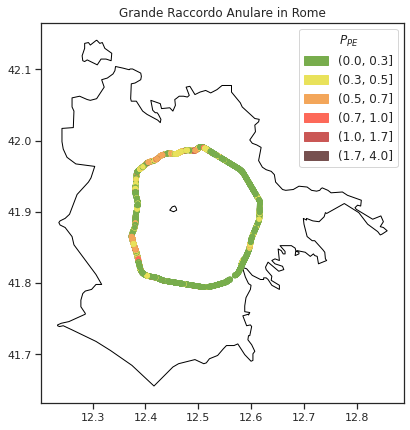

In [53]:
#plot ppe in Raccordo Anulare
rcParams['figure.figsize'] = [7, 7]
city = "Roma"
fig, ax = plt.subplots()
italy_cities[italy_cities["NOME_COM"]== city].plot(ax = ax, facecolor='none', edgecolor='black', linewidth=1) 
#alpha = 0.2, color = "grey",

data = mdfg[mdfg["osm_id"].isin(raccordo_id)]
data.plot(ax = ax, color=data.color_ppe, markersize = 20)
    
plt.legend(handles = ppe_legend, title = "$P_{PE}$" ,fontsize= 12, title_fontsize = 12)

plt.title("Grande Raccordo Anulare in Rome")
plt.savefig("fig23.svg", format='svg', transparent=True)
plt.show()

In [25]:
# percentage of points with medium-high degradation in GRA in Rome
len(data[data["ppe"]>0.3])/len(data)*100

30.312691600245252

In [26]:
# percentage of points with medium-high degradation in all motorways
len(mdf[mdf["ppe"]>0.3])/len(mdf)*100

18.27658964807627

In [27]:
# geom average of ppe in GRA 
np.exp(data["log_ppe"].mean())

0.18921504055423125

In [28]:
# geom average of ppe 
np.exp(mdf["log_ppe"].mean())

0.1341063233392166

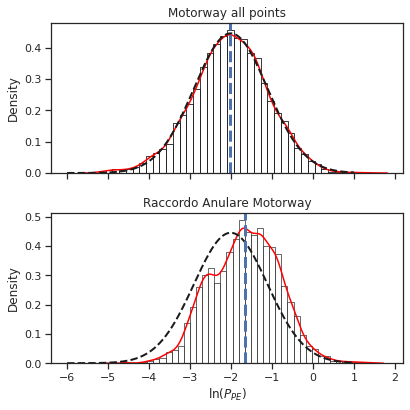

In [45]:
# plot distribution of ln(ppe) in Raccordo Anulare and a random equal-sized sample of motorway points
import random
from scipy.stats import norm

sns.set(style="ticks")

rcParams['figure.figsize'] = [6, 6]

f, (ax_hist1, ax_hist2) = plt.subplots(2, sharex=True)

# count number of GRA points
l = len(data)

# estract a sample of the same size from no bridge roads
d = random.sample(list(mdf["log_ppe"]), l )
sns.histplot(d, ax=ax_hist1, bins= 40, facecolor="white", edgecolor='black', stat= "density")
sns.kdeplot(d, ax=ax_hist1, color = "red")

# plot best fit normal distribution             
x = np.linspace(-6, 1, 1000)
mean, std = norm.fit(mdf["log_ppe"])
p = norm.pdf(x, mean, std)
ax_hist1.plot(x, p, 'k', linewidth=2, ls = "--")
ax_hist1.axvline(x = sum(d)/len(d), linewidth=3, ls = "--", color = "b")

# extract bridge points
d2 = data["log_ppe"]
sns.histplot(d2, ax=ax_hist2, bins= 40, facecolor="white", edgecolor='black', stat= "density")
sns.kdeplot(d2, ax=ax_hist2, color = "red")
ax_hist2.plot(x, p, 'k', linewidth=2, ls = "--")
ax_hist2.axvline(x = sum(d2)/len(d2), linewidth=3, ls = "--", color = "b")

# titles
ax_hist1.set_title("Motorway all points" )
ax_hist2.set_title("Raccordo Anulare Motorway")

ax_hist2.set_xlabel("ln($P_{PE}$)")
plt.tight_layout(pad=1.5)

plt.savefig("fig24.svg", format='svg', transparent=True)
plt.show()